# Imports

In [1]:
import os
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer's Relu etc. 
from torch.utils.data import Dataset, DataLoader # Preprocessing Dataset, Loading Dataset

from PIL import Image # Open Image
import torchvision.transforms as transforms # Image Processing & Augmentation i.e. Resize, Flip, Normalize etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # Measures Similarity Between Vectors 

# Device Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Compute Unified Device Architecture 
print(device)
# CUDA is NVIDIA’s platform that lets programmers use the GPU for general-purpose computing.

cuda


# Image Transforms

In [3]:
IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),          # [0,1]
])


# LOAD & EXPLORE DATASET
## Custom Dataset (No Labels) 

In [4]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# LOAD DATASET

In [5]:
IMAGE_DIR = "/kaggle/input/product-images-dataset/small/01"

dataset = ImageDataset(IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


# VISUALIZE RANDOM IMAGES (SANITY CHECK)

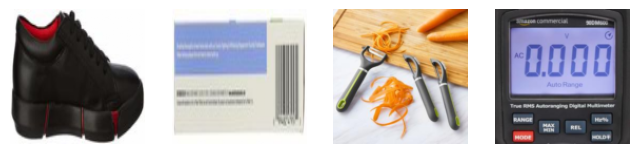

In [6]:
images = next(iter(dataloader))

plt.figure(figsize=(8,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.axis("off")
plt.show()


# DEFINE CNN AUTOENCODER (FROM SCRATCH)
## Encoder (Feature Extractor)

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128)   # embedding vector
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


## Decoder (For Reconstruction)

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(128, 128 * 16 * 16),
            nn.ReLU()
        )

        self.deconv = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 16, 16)
        x = self.deconv(x)
        return x


## Autoencoder Wrapper

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon


# INITIALIZE MODEL

In [10]:
model = Autoencoder().to(device)


# LOSS & OPTIMIZER

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# TRAIN THE AUTOENCODER

In [12]:
EPOCHS = 30

for epoch in range(EPOCHS):
    total_loss = 0
    for images in dataloader:
        images = images.to(device)

        outputs = model(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}")


Epoch [1/30], Loss: 6.0841
Epoch [2/30], Loss: 3.6656
Epoch [3/30], Loss: 2.9743
Epoch [4/30], Loss: 2.6376
Epoch [5/30], Loss: 2.4756
Epoch [6/30], Loss: 2.2778
Epoch [7/30], Loss: 2.1579
Epoch [8/30], Loss: 1.9888
Epoch [9/30], Loss: 1.8374
Epoch [10/30], Loss: 1.6908
Epoch [11/30], Loss: 1.6052
Epoch [12/30], Loss: 1.5293
Epoch [13/30], Loss: 1.4804
Epoch [14/30], Loss: 1.4244
Epoch [15/30], Loss: 1.3965
Epoch [16/30], Loss: 1.2991
Epoch [17/30], Loss: 1.2430
Epoch [18/30], Loss: 1.1761
Epoch [19/30], Loss: 1.1707
Epoch [20/30], Loss: 1.1052
Epoch [21/30], Loss: 1.0452
Epoch [22/30], Loss: 1.0412
Epoch [23/30], Loss: 1.0541
Epoch [24/30], Loss: 0.9986
Epoch [25/30], Loss: 0.9430
Epoch [26/30], Loss: 0.8966
Epoch [27/30], Loss: 0.9149
Epoch [28/30], Loss: 0.9048
Epoch [29/30], Loss: 0.8504
Epoch [30/30], Loss: 0.8261


# EXTRACT PRODUCT EMBEDDINGS

In [13]:
model.eval()

embeddings = []
image_names = dataset.image_files

with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        z = model.encoder(images)
        embeddings.append(z.cpu().numpy())

embeddings = np.vstack(embeddings)


# PROCESS USER-UPLOADED IMAGE

In [14]:
def process_query_image(path):
    image = Image.open(path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0).to(device)
    return image


In [15]:
query_image = process_query_image("/kaggle/input/product-images-dataset/small/01/01013f05.jpg")

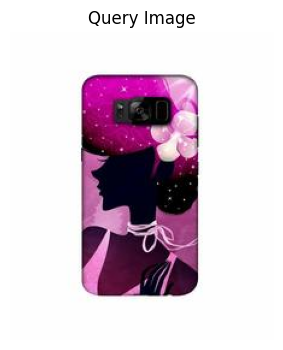

In [16]:
img = Image.open("/kaggle/input/product-images-dataset/small/01/01013f05.jpg").convert("RGB")

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis("off")
plt.title("Query Image")
plt.show()

# COMPUTE SIMILARITY

In [17]:
with torch.no_grad():
    query_embedding = model.encoder(query_image).cpu().numpy()


In [18]:
similarity = cosine_similarity(query_embedding, embeddings)

# TOP-N RECOMMENDATIONS

In [19]:
TOP_N = 5
top_indices = similarity[0].argsort()[-TOP_N:][::-1]


# SHOW RECOMMENDED IMAGES

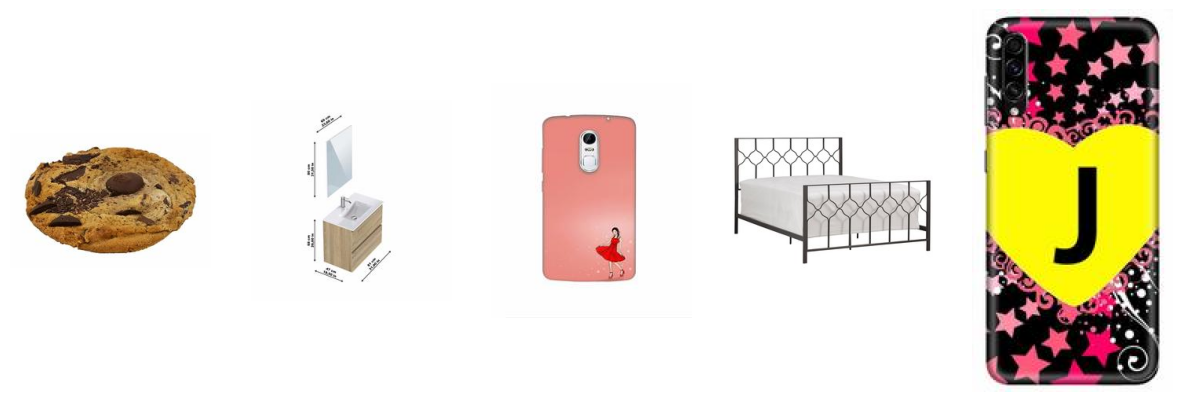

In [20]:
plt.figure(figsize=(15,5))

for i, idx in enumerate(top_indices):
    img_path = os.path.join(IMAGE_DIR, image_names[idx])
    img = Image.open(img_path)

    plt.subplot(1, TOP_N, i+1)
    plt.imshow(img)
    plt.axis("off")

plt.show()


# Exploring Fashion Product Images Dataset

In [1]:
import os
import torch
import torch.nn as nn # Neural Network
import torch.optim as optim # Optimizer's Relu etc. 
from torch.utils.data import Dataset, DataLoader # Preprocessing Dataset, Loading Dataset

from PIL import Image # Open Image
import torchvision.transforms as transforms # Image Processing & Augmentation i.e. Resize, Flip, Normalize etc. 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity # Measures Similarity Between Vectors 
import pandas as pd
import seaborn as sns

In [2]:
df_images = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/images.csv')
df_styles = pd.read_csv(
    '/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv',
    on_bad_lines='skip',
    encoding='utf-8'
)

In [3]:
df_styles.columns

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')

In [4]:
df_styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [24]:
df_updated_styles = df_styles[df_styles['gender'].isin(['Men', 'Women'])]
df_updated_styles

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
...,...,...,...,...,...,...,...,...,...,...
44419,17036,Men,Footwear,Shoes,Casual Shoes,White,Summer,2013.0,Casual,Gas Men Caddy Casual Shoe
44420,6461,Men,Footwear,Flip Flops,Flip Flops,Red,Summer,2011.0,Casual,Lotto Men's Soccer Track Flip Flop
44421,18842,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Casual,Puma Men Graphic Stellar Blue Tshirt
44422,46694,Women,Personal Care,Fragrance,Perfume and Body Mist,Blue,Spring,2017.0,Casual,Rasasi Women Blue Lady Perfume


In [5]:
df_images.head()

,filename,link
0,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


In [6]:
df_images.columns

Index(['filename', 'link'], dtype='object')

In [7]:
# Quick overview
print("Number of products in styles.csv:", len(df_styles))
print("Number of images in images.csv:", len(df_images))

Number of products in styles.csv: 44424
Number of images in images.csv: 44446


In [8]:
print("Styles CSV Shape", df_styles.shape)
print("Images CSV Shape", df_images.shape)

Styles CSV Shape (44424, 10)
Images CSV Shape (44446, 2)


# Exploratory Data Analysis

In [9]:
total_products = df_styles['id'].nunique()
print("Total unique products:", total_products)


Total unique products: 44424


# Merging Image with Meta Data

In [10]:
# Total images
df = df_styles
print("Total images:", len(df))

# Number of unique categories
print("Master categories:", df['masterCategory'].nunique())
print("Subcategories:", df['subCategory'].nunique())
print("Article types:", df['articleType'].nunique())
print("Colors:", df['baseColour'].nunique())


Total images: 44424
Master categories: 7
Subcategories: 45
Article types: 143
Colors: 46


# Class Distribution (Master Category)

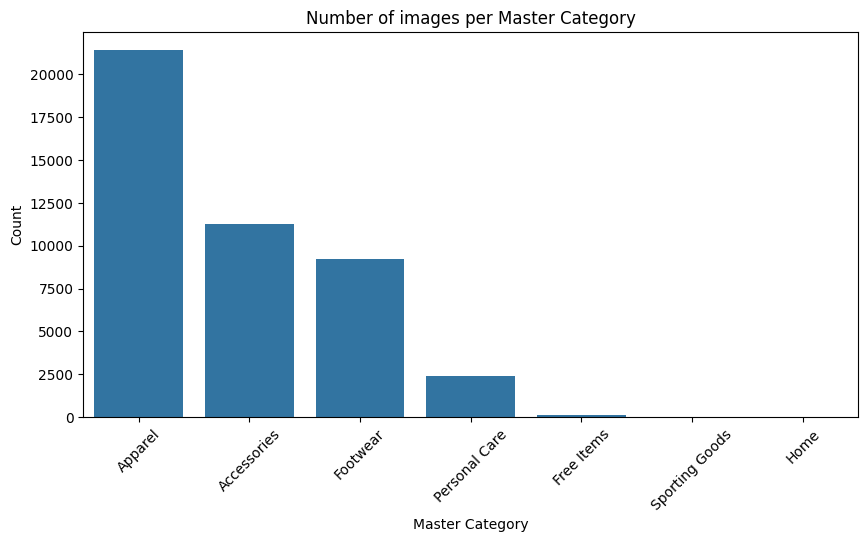

In [11]:
# Count images per masterCategory
category_counts = df['masterCategory'].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title("Number of images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()

# Subcategory Distribution

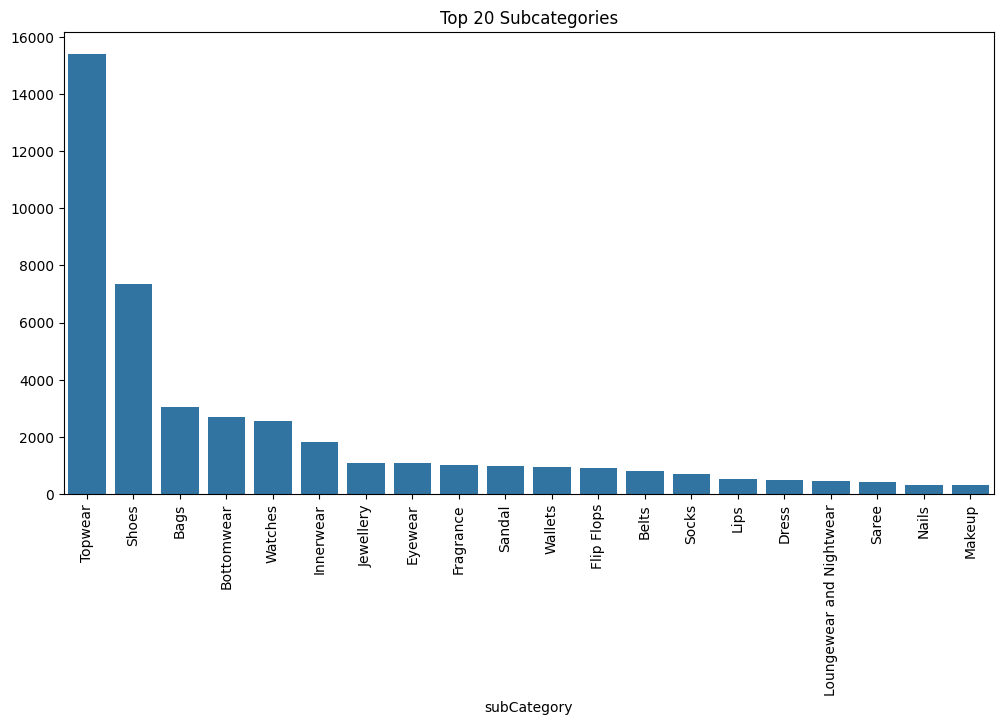

In [12]:
# Top 20 subcategories
sub_counts = df['subCategory'].value_counts().head(20)

plt.figure(figsize=(12,6))
sns.barplot(x=sub_counts.index, y=sub_counts.values)
plt.title("Top 20 Subcategories")
plt.xticks(rotation=90)
plt.show()

# Color distribution

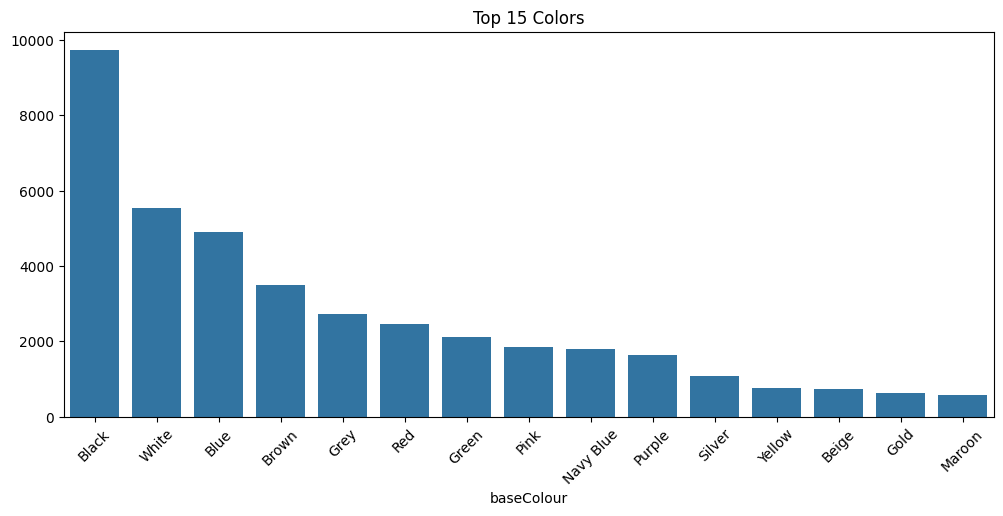

In [13]:
color_counts = df['baseColour'].value_counts().head(15)

plt.figure(figsize=(12,5))
sns.barplot(x=color_counts.index, y=color_counts.values)
plt.title("Top 15 Colors")
plt.xticks(rotation=45)
plt.show()


# Number of Images Per Master Category

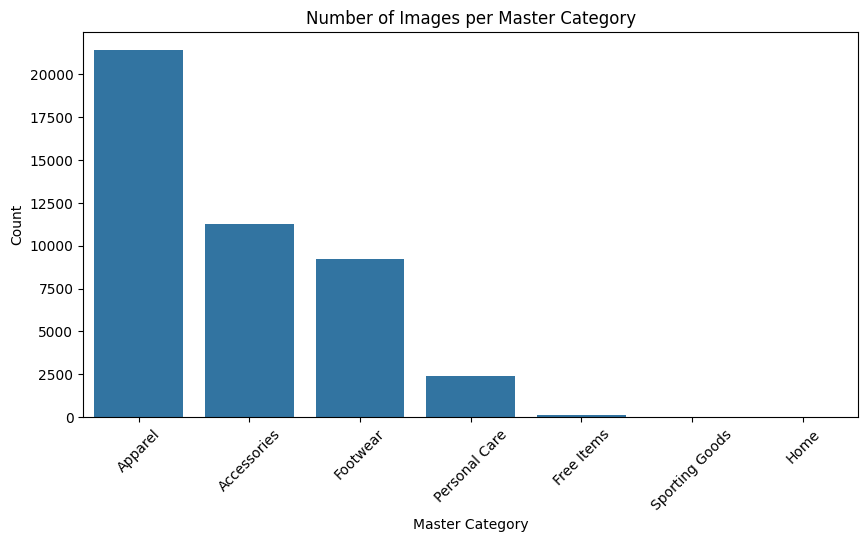

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='masterCategory', order=df['masterCategory'].value_counts().index)
plt.title("Number of Images per Master Category")
plt.ylabel("Count")
plt.xlabel("Master Category")
plt.xticks(rotation=45)
plt.show()


# Number of Images per sub category

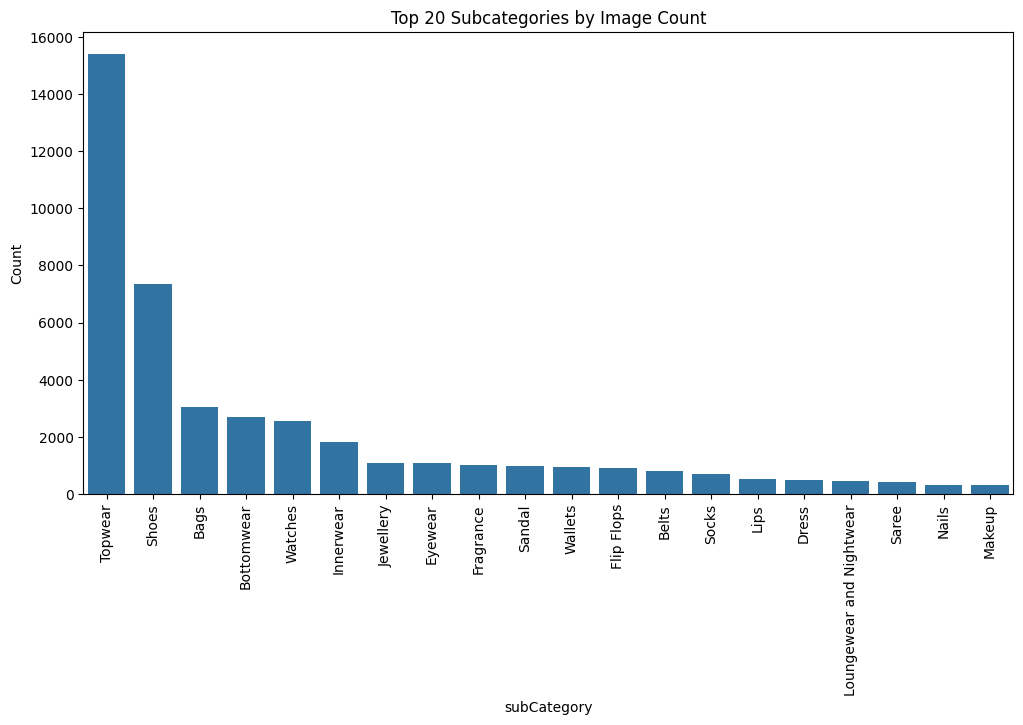

In [15]:
top_subcategories = df['subCategory'].value_counts().head(20)
plt.figure(figsize=(12,6))
sns.barplot(x=top_subcategories.index, y=top_subcategories.values)
plt.title("Top 20 Subcategories by Image Count")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.show()

# Color distribution (top 15)

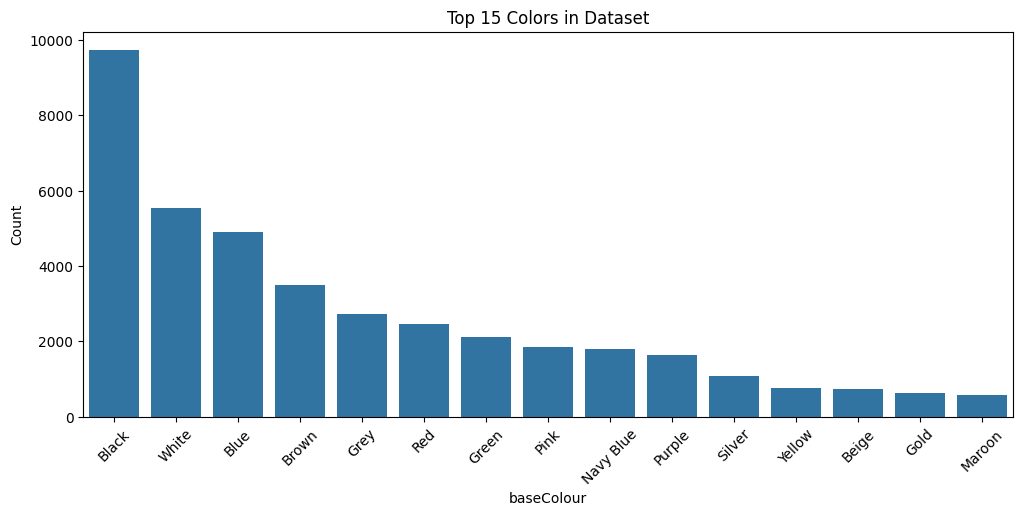

In [16]:
top_colors = df['baseColour'].value_counts().head(15)
plt.figure(figsize=(12,5))
sns.barplot(x=top_colors.index, y=top_colors.values)
plt.title("Top 15 Colors in Dataset")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


# Images per gender

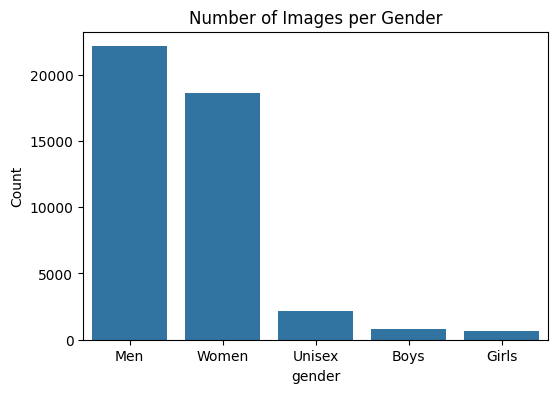

In [17]:
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Number of Images per Gender")
plt.ylabel("Count")
plt.show()


# Category vs. Gender Heatmap

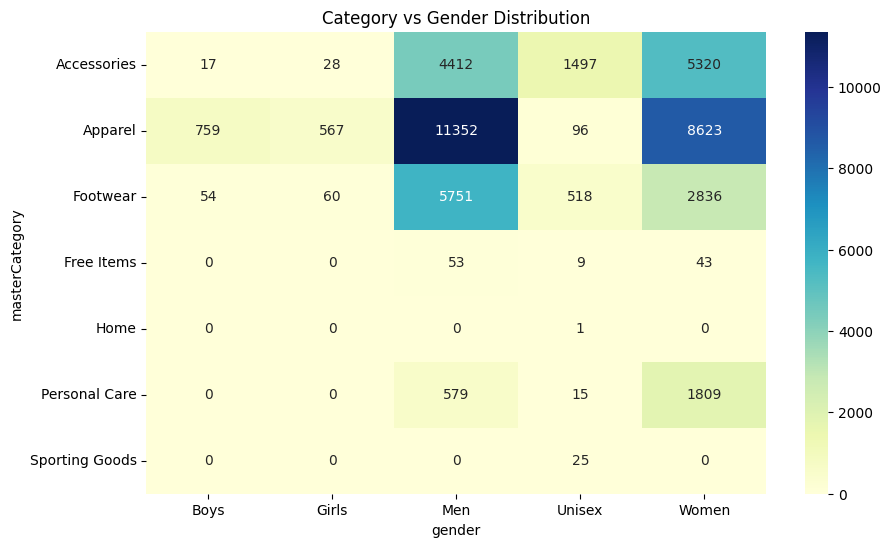

In [18]:
category_gender = pd.crosstab(df['masterCategory'], df['gender'])
plt.figure(figsize=(10,6))
sns.heatmap(category_gender, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Category vs Gender Distribution")
plt.show()


# Subcategory vs. Color Heatmap (top 20 subcategories)

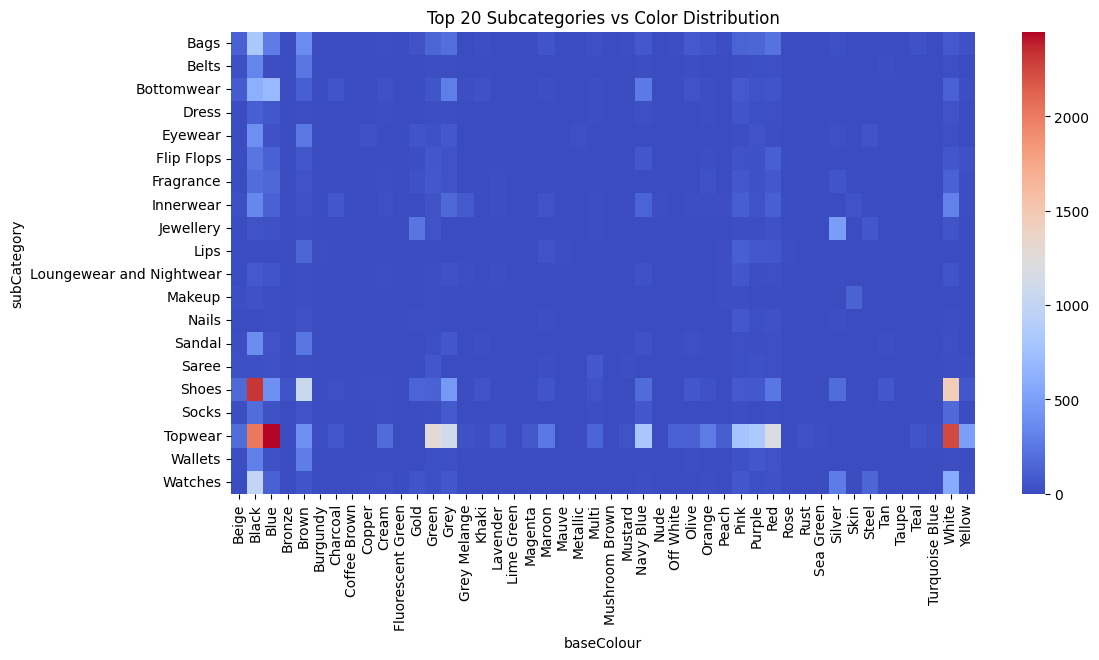

In [19]:
top_subs = df['subCategory'].value_counts().head(20).index
df_top = df[df['subCategory'].isin(top_subs)]

sub_color = pd.crosstab(df_top['subCategory'], df_top['baseColour'])
plt.figure(figsize=(12,6))
sns.heatmap(sub_color, cmap="coolwarm", annot=False)
plt.title("Top 20 Subcategories vs Color Distribution")
plt.show()
